In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://drive.google.com/uc?export=download&id=167Nqjl4Q9D-bw72qJBrAm8ZYL-ANIh2Q') 
weather = pd.read_csv('https://drive.google.com/uc?export=download&id=1F0JOQQH2tsJ72hZvtvg7Uvf_k3VyouDo')

In [0]:
df = df.replace('55c66225-fbe7-4fd5-9072-eab1ece5e23e', "UberX")
df = df.replace('6c84fd89-3f11-4782-9b50-97c468b19529', "UberBlack")
df = df.replace('6d318bcc-22a3-4af6-bddd-b409bfce1546', "UberBlackSUV")
df = df.replace('997acbb5-e102-41e1-b155-9df7de0a73f2', "UberPool")
df = df.replace('6f72dfc5-27f1-42e8-84db-ccc7a75f6969', "UberXL")
df = df.replace('9a0e7b09-b92b-4c41-9779-2ad22b4d779d', "UberWAV")
df = df.replace('8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a', "UberTaxi")
df = df.replace('Black', "UberBlack")
df = df.replace('Black SUV', "UberBlackSUV")
df = df.replace('Shared', "LyftLine")
df = df.replace('Lux Black XL', "LyftLuxBlackXL")
df = df.replace('Lyft XL', "LyftXL")
df = df.replace('Lux Black', "LyftLuxBlack")
df = df.replace('Lux', "LyftLux")


weather['rain'] = weather['rain'].fillna(0)

# **Check for null prices in the dataset and remove them**

In [0]:
# All null prices prices are UberTaxi
df[df['price'].isnull()].groupby('product_id').size()

# All UberTaxi are null prices
df[df['product_id'] == 'UberTaxi'].groupby('price').size()

# Drop "UberTaxi"
df = df[df['product_id'] != 'UberTaxi']

# **Dropping unnecesary columns**

In [0]:
df = df.drop(columns=['product_id', 'id'])

In [0]:
df = df[df['name'] != 'WAV']
df = df[df['name'] != 'LyftLux']

# **Labelling the data**

In [0]:
#df['cab_type'] = df['cab_type'].map({'Uber':1, 'Lyft':-1})
#df.groupby('cab_type').size()

# **Mapping categories to standard names**

In [0]:
df['category'] = df['name']
df['category'] = df['category'].map({'LyftLine': 'Shared', 'LyftLuxBlack': 'Luxury', 'Lyft': 'Regular', 'LyftLuxBlackXL': 'LuxuryXL', 'LyftXL': 'XL',
                                           'UberPool': 'Shared', 'UberBlack': 'Luxury', 'UberX': 'Regular', 'UberBlackSUV': 'LuxuryXL', 'UberXL': 'XL'})


In [0]:
# drop surge multiplier since Uber only has a surge multiplier of 1
df = df.drop(columns=['surge_multiplier'])

In [0]:
df.groupby(['destination', 'source']).size()

destination  source                 
Back Bay     Boston University          7235
             Fenway                     7270
             Haymarket Square           7365
             North End                  7845
             Northeastern University    7350
                                        ... 
West End     Fenway                     7800
             Haymarket Square           7020
             North End                  7070
             Northeastern University    7310
             South Station              7325
Length: 72, dtype: int64

# **Extracting date/time/day of the week from timestamp**

In [0]:
import datetime 
import time

df['hour_of_day'] = df['time_stamp']
df['date'] = df['time_stamp']
df['day_of_week'] = df['time_stamp']


df['hour_of_day'] = df['hour_of_day'].apply(lambda x: time.strftime('%H', time.localtime(x/1000)))
df['date'] = df['date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).date())
df['day_of_week'] = df['day_of_week'].apply(lambda x: time.strftime('%A', time.localtime(x/1000)))

In [0]:
weather['hour_of_day'] = weather['time_stamp']
weather['date'] = weather['time_stamp']
weather['day_of_week'] = weather['time_stamp']


weather['hour_of_day'] = weather['hour_of_day'].apply(lambda x: time.strftime('%H', time.localtime(x)))
weather['date'] = weather['date'].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
weather['day_of_week'] = weather['day_of_week'].apply(lambda x: time.strftime('%A', time.localtime(x)))

In [0]:
def price_dist(p,d):
  return p/d

# **Cross-referencing weather at different times with times in the dataset (df)**

In [0]:
# dropping duplicates
df2 = pd.merge(df, weather, left_on=['date', 'hour_of_day', 'source'], right_on = ['date', 'hour_of_day', 'location'])
df2 = df2.drop(columns=['location', 'name'])
df2['hour_of_day'] = pd.to_numeric(df2['hour_of_day'])

In [0]:
lyft = df[df.cab_type == 'Lyft']
lyft = lyft[['date', 'hour_of_day', 'source', 'destination', 'category', 'price','distance']]
uber = df[df.cab_type == 'Uber']
uber = uber[['date', 'hour_of_day', 'source', 'destination', 'category', 'price','distance']]
lyft['price_per_dist_l'] = lyft.price/lyft.distance
uber['price_per_dist_u'] = uber.price/uber.distance
merged = pd.merge(uber, lyft, on=['date', 'hour_of_day', 'source', 'destination', 'category'])
merged2 = pd.merge(merged, weather, left_on=['date', 'hour_of_day', 'source'], right_on = ['date', 'hour_of_day', 'location'])

In [0]:
#merged2['u_price_dist'] = merged.price_x/merged.distance_x

In [0]:
merged2.head()

,date,hour_of_day,source,destination,category,price_x,distance_x,price_per_dist_u,price_y,distance_y,price_per_dist_l,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,day_of_week
0,2018-11-30,22,North End,West End,XL,12.0,1.11,10.810811,13.5,1.25,10.800000,38.65,North End,0.96,1017.23,0.0,1543618374,0.65,3.13,Friday
1,2018-11-30,22,North End,West End,XL,12.0,1.11,10.810811,13.5,1.26,10.714286,38.65,North End,0.96,1017.23,0.0,1543618374,0.65,3.13,Friday
2,2018-11-30,22,North End,West End,XL,12.0,1.11,10.810811,10.5,1.25,8.400000,38.65,North End,0.96,1017.23,0.0,1543618374,0.65,3.13,Friday
3,2018-11-30,22,North End,West End,XL,13.0,1.11,11.711712,13.5,1.25,10.800000,38.65,North End,0.96,1017.23,0.0,1543618374,0.65,3.13,Friday
4,2018-11-30,22,North End,West End,XL,13.0,1.11,11.711712,13.5,1.26,10.714286,38.65,North End,0.96,1017.23,0.0,1543618374,0.65,3.13,Friday


In [0]:
# deleting date for now (also day of week)

In [0]:
merged2 = merged2.drop(columns=['distance_x','distance_y','price_x','price_y','location','date','day_of_week','time_stamp'])

In [0]:
binary = pd.get_dummies(merged2, columns=['source','destination', 'category'])

In [0]:
binary.loc[binary['price_per_dist_u'] < binary['price_per_dist_l'], 'lowest_cost'] = 1 
binary.loc[binary['price_per_dist_u'] > binary['price_per_dist_l'], 'lowest_cost'] = 0 
binary.loc[binary['price_per_dist_u'] == binary['price_per_dist_l'], 'lowest_cost'] = -1 

In [0]:
binary.head()

,hour_of_day,price_per_dist_u,price_per_dist_l,temp,clouds,pressure,rain,humidity,wind,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,destination_Back Bay,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,category_Luxury,category_LuxuryXL,category_Regular,category_Shared,category_XL,lowest_cost
0,22,10.810811,10.800000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
1,22,10.810811,10.714286,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
2,22,10.810811,8.400000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
3,22,11.711712,10.800000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
4,22,11.711712,10.714286,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0


In [0]:
#binary = binary.drop(columns=['price_per_dist_x','price_per_dist_y'])

In [0]:
#  0: Lyft is Cheaper
#  1: Uber is Cheaper
# -1: Same price

binary.groupby('lowest_cost').size()

lowest_cost
-1.0      4174
 0.0    918503
 1.0    680800
dtype: int64

In [0]:
binary.shape

(1603477, 39)

In [0]:
#binary.groupby('date').size()
binary.head()
binary.isna().sum()


hour_of_day                            0
price_per_dist_u                       0
price_per_dist_l                       0
temp                                   0
clouds                                 0
pressure                               0
rain                                   0
humidity                               0
wind                                   0
source_Back Bay                        0
source_Beacon Hill                     0
source_Boston University               0
source_Fenway                          0
source_Financial District              0
source_Haymarket Square                0
source_North End                       0
source_North Station                   0
source_Northeastern University         0
source_South Station                   0
source_Theatre District                0
source_West End                        0
destination_Back Bay                   0
destination_Beacon Hill                0
destination_Boston University          0
destination_Fenw

In [0]:
binary.head()

,hour_of_day,price_per_dist_u,price_per_dist_l,temp,clouds,pressure,rain,humidity,wind,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,destination_Back Bay,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,category_Luxury,category_LuxuryXL,category_Regular,category_Shared,category_XL,lowest_cost
0,22,10.810811,10.800000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
1,22,10.810811,10.714286,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
2,22,10.810811,8.400000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
3,22,11.711712,10.800000,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0
4,22,11.711712,10.714286,38.65,0.96,1017.23,0.0,0.65,3.13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0


# CART


In [0]:
cart = binary.copy()
cart = cart.drop(columns=['price_per_dist_u', 'price_per_dist_l'])

In [0]:
x = cart.drop(['lowest_cost'], axis=1)
y = cart['lowest_cost']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=3)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import SVG
from graphviz import Source

# Train the CART model
cart_model = DecisionTreeClassifier(random_state=3,max_depth=50)
cart_model.fit(x_train, y_train)
train_score = cart_model.score(x_train, y_train)
test_score = cart_model.score(x_test, y_test)

# Print out summary of model performance 
print('The score of this model over training data is {:.3f} and {:.3f} over the testing data'.format(train_score, test_score))

# Visualize the decision tree
# cart_graph = Source(export_graphviz(cart_model,
#                    feature_names = cart.columns[1:],
#                    rounded = True, proportion = False, 
#                   filled = True))
# SVG(cart_graph.pipe(format='svg'))

The score of this model over training data is 0.800 and 0.753 over the testing data


## Logistic Regression

In [0]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

# Predict the number of wins
logreg.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([0., 0., 0., ..., 0., 1., 0.])

In [0]:
train_score = logreg.score(x_train, y_train)
test_score = logreg.score(x_test, y_test)

print('The train score is {} and the test score is {}'.format(train_score, test_score))

The train score is 0.6989851339766496 and the test score is 0.6998004339050701


Model Engineering

In [0]:
binary.corr().lowest_cost.sort_values()

category_Shared                       -0.337101
source_Haymarket Square               -0.118169
source_Theatre District               -0.078013
source_North End                      -0.075899
destination_Haymarket Square          -0.062132
source_North Station                  -0.056513
price_per_dist_u                      -0.047749
destination_Boston University         -0.032027
category_XL                           -0.027370
category_Regular                      -0.021013
destination_North Station             -0.020236
source_West End                       -0.017175
source_Beacon Hill                    -0.009494
destination_Fenway                    -0.005602
wind                                  -0.003885
pressure                              -0.000849
humidity                               0.000992
destination_North End                  0.001012
rain                                   0.002261
clouds                                 0.002804
destination_Theatre District           0

In [0]:
logreg.predict(x_test).sum() 

223263.0

In [0]:
# logregl1 = LogisticRegression(penalty='l1')
# logregl1.fit(x_train, y_train)

# # Partition the testing data into features and target
# #x_test = df_test.drop(columns=['W','Team','SeasonEnd', 'Playoffs'])
# #y_test = df_test.Playoffs

# # calculate the score
# train_score = logregl1.score(x_train, y_train)
# test_score = logregl1.score(x_test, y_test)
# print('The train score is {} and the test score is {}'.format(train_score, test_score))


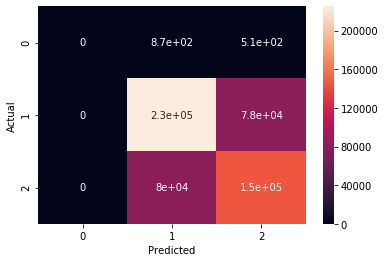

In [0]:
from sklearn.metrics import confusion_matrix


y_pred = logreg.predict(x_test)
cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(cfm, annot=True)
ax.set(xlabel='Predicted', ylabel='Actual');

In [0]:
merged2.groupby(['source','destination']).size()

source    destination            
Back Bay  Boston University          23385
          Fenway                     20330
          Haymarket Square           20750
          North End                  25345
          Northeastern University    24029
                                     ...  
West End  Fenway                     24031
          Haymarket Square           21041
          North End                  21824
          Northeastern University    19801
          South Station              20406
Length: 72, dtype: int64

In [0]:
def fit_and_score_model(mdl, x_train, x_test, y_train, y_test, random_state=0):
    """
    This function will fit and score the input mdl to the x_train and y_train 
    data, and score the mdl on y_train and y_test. To ensure results are 
    reproducible we can also set a random state.
    """
  
    # Fit an arbitrary model
    mdl.fit(x_train, y_train)
    
    # Calculate the score of the model on training and testing data
    train_score = mdl.score(x_train, y_train)
    test_score = mdl.score(x_test, y_test)
  
    # Print scores to terminal
    print('the accuracy on the: \n\t training data is {}'.format(round(train_score,3)))
    print('\t testing data is {}'.format(round(test_score, 3)))
    
    return train_score, test_score
  
# As an example, you can now call the function fit_and_score_model
train_score, test_score = fit_and_score_model(cart_model, x_train, x_test, y_train, y_test)

the accuracy on the: 
	 training data is 0.8
	 testing data is 0.753


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Write your code here. 

# -------------------

depths = [2, 3, 4, 5, 6, 7]
accuracy = pd.Series(index=depths)

for max_depth in depths:

    # Initialize the model
    rf_baseline_model = RandomForestClassifier(
        random_state = 0, 
        max_depth = max_depth,
        n_estimators = 50, max_features = 0.2
    )
    
    # Fit and train model
    print('For {} max_depth '.format(max_depth), end='')
    train_score, test_score = fit_and_score_model(rf_baseline_model, x_train, x_test, y_train, y_test)
    
    # Save model performance to dataframe
    cheat_scores.loc[max_depth] = test_score
    
print('\n***Best model has a score of {:.3f} with a max_depth of {}***'.format(cheat_scores.max(), cheat_scores.idxmax()))

For 2 max_depth the accuracy on the: 
	 training data is 0.651
	 testing data is 0.649


NameError: ignored

### Cross Validation 

In [0]:
from sklearn.model_selection import cross_validate

# Initailize cross validation score DataFrame
depth_lb = 20
depth_ub = 80
cv_scores = pd.Series(index=np.arange(depth_lb, depth_ub))

for max_depth in range(depth_lb, depth_ub):
  
  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = max_depth,
                          n_estimators = 50, max_features = 0.20)
  print("hi")
  print(max_depth)
  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, x_train, y_train, cv=5)
  print("bye")
  # Record the average out-of-sample error
  cv_scores.loc[max_depth] = example_cv_results['test_score'].mean()

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score

param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'max_features' : list(range(1,x_train.shape[1])),
              'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)} 

grid_srch_rf = tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_rf.fit(x_train, y_train)
grid_srch_rf.best_estimator_

# mdl = DecisionTreeClassifier(random_state=1)
# optimized_dt = GridSearchCV(mdl, params_to_search, scoring = ['recall', 'precision'], refit=False, cv=5)

# print("Precision Score : ", precision_score(y_test, y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))
# print("Precision Score : ", recall_score(y_test, y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))



# optimized_dt.fit(x_train, y_train)


# clf = GridSearchCV(estimator=RandomForestClassifier(), 
#                     param_grid=params_to_search,
#                     cv=5,
#                     refit=True,
#                     error_score=0,
#                     n_jobs=-1)


# clf.fit(x_train, y_train)

In [0]:
clf.get_params().keys()

In [0]:
df.head()
df.groupby('source').size()

## K-Clustering 

In [0]:
k_df = df.copy()
k_df.head()
k_df = pd.merge(k_df, weather, left_on=['date', 'hour_of_day', 'source'], right_on = ['date', 'hour_of_day', 'location'])
k_df.head()

In [0]:
#drop categoricals, analysis for clustering will be time of day, distance and weather 

In [0]:
kmeans = binary.copy()

In [0]:
#k_df= k_df.drop(columns = ["day_of_week_x", "destination", "location", "time_stamp_x"])


#k_df['day_of_week'] = k_df['day_of_week'].apply(lambda x: 1 if x == ["Saturday", "Sunday"] else 0)
k_df= k_df.drop(columns = ["day_of_week_y"])
k_df= k_df.drop(columns = ["time_stamp_y"])
k_df= k_df.drop(columns = ["name", "date"])
k_df= k_df.drop(columns = ["cab_type"])


k_df = pd.get_dummies(k_df, columns=['source','category'])
k_df.head()

In [0]:
from sklearn.preprocessing import StandardScaler

def standarize(x_train, x_test, columns):
    scaler = StandardScaler()
    x_train[columns] = scaler.fit_transform(x_train[columns])
    x_test[columns] = scaler.transform(x_test[columns])
                        
    return x_train, x_test

In [0]:
x = k_df.drop(columns = ["price"])
y = k_df.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=3)



columns_to_scale = ['distance', 'temp', 'hour_of_day', 'clouds', 'pressure', 'rain',
                    'humidity', 'wind']
X_train_scaled, X_test_scaled = standarize(x_train, x_test, columns_to_scale)

In [0]:
from sklearn.cluster import KMeans

# Define clustering model 
mdk_k_means = KMeans(n_init = 1,  # number of different centroid seed initializations (number of times algorithm is run)
                   n_clusters= 12,  # number of clusters (k)
                   random_state = 1)  # random seed for k-means algorithm

# Fit the model to the training set
mdk_k_means.fit(X_train_scaled)#[non_binary_columns])

# Get cluster assignments for each datapoint
clK = mdk_k_means.labels_

# Get the centroid of each cluster
Centroids = mdk_k_means.cluster_centers_


In [0]:
k_df['clusters'] = clK
columns_to_scale.extend['clusters']
print(df_k[columns_to_scale].groupby(['clusters']).mean())
